In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import collections
import seaborn as sns
import time, datetime
# from node2vec import Node2Vec
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
from scipy.spatial import distance
from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import squareform
from IPython.display import display

%matplotlib notebook
sns.set_palette("Set2")

#### Read Data

In [5]:
# 거래 데이터 read
df = pd.read_csv('dataset/추가 산업 분류 코드 작업_20211025/산업내/NICE_COMPANY_BUSINESS_2019_부품_자동차.csv',
                 encoding='CP949', engine='python')
# df = pd.read_excel('dataset/추가 산업 분류 코드 작업_20211025/산업내/NICE_COMPANY_BUSINESS_2019_부품_전기공급및전기제어장치.xlsx'
#                  )

# 분석 타겟 산업분류코드 입력
current_industry_code = 'C30'
current_year = '2019'
current_industry_code

'C30'

In [6]:
df.head()

,Unnamed: 0,SEQ,YEAR,REGISTRATION_NUMBER,COMPANYNAME,REPRESENTATIVE,INDUSTRY_CODE,INDUSTRY_CODENM,ADDRESS,GUBUN,CUS_REGISTRATION_NUMBER,CUS_COMPANYNAME,CUS_ADDRESS,CUS_ADDRESS_DETAIL,CUS_INDUSTRY_CODE,CUS_INDUSTRY_CODENM,CUSTOM_RATIO,CUSTOM_VALUE
0,325988,81610601,2019,6088156952,(주)부일,김관곤/김봉균,C30122,화물자동차 및 특수목적용 자동차 제조업,경남 창원시 마산합포구 진북면 진북산업로 459,매출처,7018100489,(주)성진테크,경기 화성시,경기 화성시 팔탄면 시청로 997,C30201,차체 및 특장차 제조업,0.0,400000.0
1,332109,81486583,2019,8558801144,김포현대일급자동차공업사(주),김홍규,C30122,화물자동차 및 특수목적용 자동차 제조업,경기 김포시 대곶면 율마로 33,매출처,1378164867,(주)금강특장차,인천 서구,인천 서구 북항로 28-46,C30110,자동차용 엔진 제조업,77.0,379483633.0
2,340474,81486593,2019,8558801144,김포현대일급자동차공업사(주),김홍규,C30122,화물자동차 및 특수목적용 자동차 제조업,경기 김포시 대곶면 율마로 33,매출처,1378167656,(주)태영특장,인천 서구,"인천 서구 한서로 86, ,212-227",C30201,차체 및 특장차 제조업,0.0,300000.0
3,340490,81486609,2019,8558801144,김포현대일급자동차공업사(주),김홍규,C30122,화물자동차 및 특수목적용 자동차 제조업,경기 김포시 대곶면 율마로 33,매출처,1053434227,엠제이글로벌,경기 남양주시,"경기 남양주시 오남읍 진건오남로512번길 25-1, 109동 101호",C30121,승용차 및 기타 여객용 자동차 제조업,0.0,718182.0
4,340504,81486623,2019,8558801144,김포현대일급자동차공업사(주),김홍규,C30122,화물자동차 및 특수목적용 자동차 제조업,경기 김포시 대곶면 율마로 33,매출처,1378181809,(주)금강자동차,인천 서구,"인천 서구 북항로 28-46, A동 1층",C30122,화물자동차 및 특수목적용 자동차 제조업,6.0,29090909.0


In [7]:
df.tail()

,Unnamed: 0,SEQ,YEAR,REGISTRATION_NUMBER,COMPANYNAME,REPRESENTATIVE,INDUSTRY_CODE,INDUSTRY_CODENM,ADDRESS,GUBUN,CUS_REGISTRATION_NUMBER,CUS_COMPANYNAME,CUS_ADDRESS,CUS_ADDRESS_DETAIL,CUS_INDUSTRY_CODE,CUS_INDUSTRY_CODENM,CUSTOM_RATIO,CUSTOM_VALUE
23127,8277895,88554113,2019,7828801244,(주)그린라인,NaN,C30400,자동차 재제조 부품 제조업,전북 김제시 백산면 지평선산단5길 139-14,매출처,8338600160,(주)한국몰드김제,NaN,전북 김제시 백산면 대동공단2길 38,C30399,그 외 자동차용 신품 부품 제조업,NaN,2.445000e+07
23128,8506619,88877237,2019,3482200807,퍼펙트,NaN,C30400,자동차 재제조 부품 제조업,"충남 천안시 서북구 백석공단4길 12, 1동 1층",매출처,3128122420,(주)모베이스코넥타,NaN,충남 천안시 서북구 3공단4로 40,C30399,그 외 자동차용 신품 부품 제조업,NaN,3.960506e+08
23129,8666611,89765979,2019,7858701187,(주)창평기업,NaN,C30400,자동차 재제조 부품 제조업,경북 경주시 외동읍 모화산단길 68-10,매출처,5158107635,아진산업(주),NaN,경북 경산시 진량읍 공단8로26길 40,C30320,자동차 차체용 신품 부품 제조업,NaN,4.709419e+09
23130,8861320,90349738,2019,6220192535,신흥정공,NaN,C30400,자동차 재제조 부품 제조업,부산 강서구 신덕길2번길 88,매출처,6208110295,(주)디아이씨,NaN,울산 울주군 두동면 봉계농공길 8,C30331,자동차용 신품 동력전달장치 제조업,NaN,7.724600e+06
23131,8942871,90076589,2019,6208153182,한올협동조합,NaN,C30400,자동차 재제조 부품 제조업,울산 북구 관문길 149-1,매출처,6200671903,창성기업,NaN,경북 경주시 외동읍 내외로 90-82,C30320,자동차 차체용 신품 부품 제조업,NaN,1.866348e+07


In [8]:
df.drop_duplicates(inplace=True)
df = df.dropna(axis=0, subset=['REGISTRATION_NUMBER', 'CUS_REGISTRATION_NUMBER'])
df.tail()

,Unnamed: 0,SEQ,YEAR,REGISTRATION_NUMBER,COMPANYNAME,REPRESENTATIVE,INDUSTRY_CODE,INDUSTRY_CODENM,ADDRESS,GUBUN,CUS_REGISTRATION_NUMBER,CUS_COMPANYNAME,CUS_ADDRESS,CUS_ADDRESS_DETAIL,CUS_INDUSTRY_CODE,CUS_INDUSTRY_CODENM,CUSTOM_RATIO,CUSTOM_VALUE
23127,8277895,88554113,2019,7828801244,(주)그린라인,NaN,C30400,자동차 재제조 부품 제조업,전북 김제시 백산면 지평선산단5길 139-14,매출처,8338600160,(주)한국몰드김제,NaN,전북 김제시 백산면 대동공단2길 38,C30399,그 외 자동차용 신품 부품 제조업,NaN,2.445000e+07
23128,8506619,88877237,2019,3482200807,퍼펙트,NaN,C30400,자동차 재제조 부품 제조업,"충남 천안시 서북구 백석공단4길 12, 1동 1층",매출처,3128122420,(주)모베이스코넥타,NaN,충남 천안시 서북구 3공단4로 40,C30399,그 외 자동차용 신품 부품 제조업,NaN,3.960506e+08
23129,8666611,89765979,2019,7858701187,(주)창평기업,NaN,C30400,자동차 재제조 부품 제조업,경북 경주시 외동읍 모화산단길 68-10,매출처,5158107635,아진산업(주),NaN,경북 경산시 진량읍 공단8로26길 40,C30320,자동차 차체용 신품 부품 제조업,NaN,4.709419e+09
23130,8861320,90349738,2019,6220192535,신흥정공,NaN,C30400,자동차 재제조 부품 제조업,부산 강서구 신덕길2번길 88,매출처,6208110295,(주)디아이씨,NaN,울산 울주군 두동면 봉계농공길 8,C30331,자동차용 신품 동력전달장치 제조업,NaN,7.724600e+06
23131,8942871,90076589,2019,6208153182,한올협동조합,NaN,C30400,자동차 재제조 부품 제조업,울산 북구 관문길 149-1,매출처,6200671903,창성기업,NaN,경북 경주시 외동읍 내외로 90-82,C30320,자동차 차체용 신품 부품 제조업,NaN,1.866348e+07


### 함수 선언

In [9]:
# 최적 클러스터 수 판별

def elbow(X, dim):
    sse = []
    for i in range(2, dim):
        km = KMeans(n_clusters=i, random_state=42)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(2, dim), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show


def cal_silhouette(X, dim, method='km'):
    silhouette_vals = []
    if method == 'km':
        for i in range(2, dim):
            print('processing %d clusters k-means' %i)
            km = KMeans(n_clusters=i, random_state=42)
            pred = km.fit_predict(X)
            silhouette_vals.append(np.mean(silhouette_samples(X, pred, metric='euclidean')))
        print(method)
    elif method == 'agg':
        for i in range(2, dim):
            print('processing %d clusters agglomerative' %i)
            agg = AgglomerativeClustering(n_clusters=i)
            pred = agg.fit_predict(X)
            silhouette_vals.append(np.mean(silhouette_samples(X, pred, metric='euclidean')))
        print(method)
    
    plt.plot(range(2, dim), silhouette_vals, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette')
    plt.show()
    
    


In [46]:
def calculate_module_parameter(df_data: pd.DataFrame, step: int, current_industry_code=current_industry_code):
    module_custom_avg = {}

    module_bet_avg = {}
    module_cls_avg = {}
    module_id_avg = {}
    module_od_avg = {}
    module_bet_std_dev = {}
    module_cls_std_dev = {}
    module_od_std_dev = {}
    module_id_std_dev = {}
    module_out_node_from_diff = {}
    module_in_node_from_diff = {}
    module_odid_ratio = {}
    module_num_nodes = {}
    module_num_industry = {}

    num_clusters = sorted(collections.Counter(df_data[f'Cluster_{step}']))

    for i in num_clusters:
        ## 모듈별 betweenness centrality STD.DEV., 산업내,외 노드 수 계산
        N_cluster = df_data[df_data[f'Cluster_{step}'] == i]
        contains_IDcode = N_cluster['INDUSTRY_CODE'].str.contains(current_industry_code)

        module_custom_avg[i] = np.mean(N_cluster['Custom_value'])

        module_bet_avg[i] = np.mean(N_cluster['Betweenness_Cen.'])
        module_cls_avg[i] = np.mean(N_cluster['Closeness_Cen.'])
        module_od_avg[i] = np.mean(N_cluster['Out-Degree_Cen.'])
        module_id_avg[i] = np.mean(N_cluster['In-Degree_Cen.'])
        module_bet_std_dev[i] = np.std(N_cluster['Betweenness_Cen.'])
        module_cls_std_dev[i] = np.std(N_cluster['Closeness_Cen.'])
        module_od_std_dev[i] = np.std(N_cluster['Out-Degree_Cen.'])
        module_id_std_dev[i] = np.std(N_cluster['In-Degree_Cen.'])
        module_odid_ratio[i] = module_od_avg[i] / module_id_avg[i]
        module_num_nodes[i] = len(N_cluster)
        module_num_industry[i] = collections.Counter(contains_IDcode)[True]

        print(i, " the number of nodes: ", len(N_cluster))
        print(i, " module's B Cen. Avg: %.8f" %np.mean(N_cluster['Betweenness_Cen.']))
        print(i, " module's C Cen. Avg: %.8f" %np.mean(N_cluster['Closeness_Cen.']))
        print(i, " module's OD Cen. Avg: %.8f" %np.mean(N_cluster['Out-Degree_Cen.']))
        print(i, " module's OD Cen. STD.dev: %.8f" %np.std(N_cluster['Out-Degree_Cen.']))
        print(i, " module's ID Cen. Avg: %.8f" %np.mean(N_cluster['In-Degree_Cen.']))
        print(i, " module's ID Cen. STD.dev: %.8f" %np.std(N_cluster['In-Degree_Cen.']))
        print(i, " module's", current_industry_code, ': ', collections.Counter(contains_IDcode)[True])
        print(i, " module's not", current_industry_code, ': ', collections.Counter(contains_IDcode)[False])
        print('')
        
#     자료정리용
    tmp_df = pd.DataFrame({
                          '# of in_industry': module_num_industry.values(),
                          'Custom avg.': module_custom_avg.values(),
                          'Custom rank': np.nan,
                          'Bet. avg.': module_bet_avg.values(),
                          'Bet. rank': np.nan,
#                           'Bet. Std.dev.': module_bet_std_dev.values(),
                          'Cls. avg.': module_cls_avg.values(),
                          'Cls. rank': np.nan,
#                           'Cls. Std.dev.': module_cls_std_dev.values(),
                          'OD avg.': module_od_avg.values(),
                          'OD rank': np.nan,
#                           'OD Std.dev.': module_od_std_dev.values(),
                          'ID avg.': module_id_avg.values(),
                          'ID rank': np.nan,
#                           'ID Std.dev': module_id_std_dev.values(),
                          'OD/ID': module_odid_ratio.values()
    })
    tmp_df['Custom rank'] = tmp_df['Custom avg.'].rank(method='dense', ascending=False)
    tmp_df['Bet. rank'] = tmp_df['Bet. avg.'].rank(method='dense', ascending=False)
    tmp_df['Cls. rank'] = tmp_df['Cls. avg.'].rank(method='dense', ascending=False)
    tmp_df['OD rank'] = tmp_df['OD avg.'].rank(method='dense', ascending=False)
    tmp_df['ID rank'] = tmp_df['ID avg.'].rank(method='dense', ascending=False)
    # tmp_df = tmp_df.transpose()
    display(tmp_df)

### 그래프 생성

In [11]:
## make graph by edgelist
## create_using: choose type of graph
G1 = nx.from_pandas_edgelist(df, 'REGISTRATION_NUMBER', 'CUS_REGISTRATION_NUMBER', 
                             edge_attr='CUSTOM_VALUE', 
                             create_using=nx.DiGraph())

In [12]:
print(G1.number_of_nodes())
print(G1.number_of_edges())

6117
23132


In [13]:
# convert node labels to integers and add registration number as the label attribute
G = nx.convert_node_labels_to_integers(G1, first_label=0, label_attribute='REG no.')

In [14]:
REG_to_COM = {}

for i in G.nodes():
    REG_to_COM[i] = G.nodes[i]['REG no.']
    i = i+1
    
print(i)
print(len(REG_to_COM))

6117
6117


In [15]:
REG_to_COM

{0: 6088156952,
 1: 7018100489,
 2: 8558801144,
 3: 1378164867,
 4: 1378167656,
 5: 1053434227,
 6: 1378181809,
 7: 1282214629,
 8: 1398113699,
 9: 1338119093,
 10: 1248644180,
 11: 5058171407,
 12: 1248172755,
 13: 1238120157,
 14: 1248707391,
 15: 1288636417,
 16: 6888801113,
 17: 1061327025,
 18: 8080900047,
 19: 1378700958,
 20: 2587000150,
 21: 1058141381,
 22: 6088119694,
 23: 2118639754,
 24: 6098135187,
 25: 1378144750,
 26: 1398121151,
 27: 1248654198,
 28: 6081820877,
 29: 1248653393,
 30: 4108196565,
 31: 1348101989,
 32: 6098101770,
 33: 3108112926,
 34: 6208140348,
 35: 6098108002,
 36: 6208121996,
 37: 6738601102,
 38: 5538600963,
 39: 8598700868,
 40: 4120385329,
 41: 2063095500,
 42: 1438124098,
 43: 5428800176,
 44: 1338136485,
 45: 3018603414,
 46: 3128156385,
 47: 4108703694,
 48: 1198102316,
 49: 1238145333,
 50: 1370665520,
 51: 4598600263,
 52: 3018615550,
 53: 1748600474,
 54: 3178105921,
 55: 4028179134,
 56: 1078659937,
 57: 7438600741,
 58: 3068101721,
 59: 65

In [16]:
reg_num = list(REG_to_COM.values())
idx_cell = df.index[(df['REGISTRATION_NUMBER'] == reg_num[1]) ].tolist()
idx_cus = df.index[(df['CUS_REGISTRATION_NUMBER'] == reg_num[1])].tolist()

In [17]:
company_name = []
industry_code = []

for reg in reg_num:
    idx_cell = df.index[(df['REGISTRATION_NUMBER'] == reg)].tolist()
    idx_cus = df.index[(df['CUS_REGISTRATION_NUMBER'] == reg)].tolist()
    
    if not idx_cell:
        company_name.append(df.loc[idx_cus[0]]['CUS_COMPANYNAME'])
        industry_code.append(df.loc[idx_cus[0]]['CUS_INDUSTRY_CODE'])
    else:
        company_name.append(df.loc[idx_cell[0]]['COMPANYNAME'])
        industry_code.append(df.loc[idx_cell[0]]['INDUSTRY_CODE'])

print('total number of company: ', len(company_name))
print('industry code length: ', len(industry_code))
print('======'*8)
print(company_name)
print(industry_code)

total number of company:  6117
industry code length:  6117
['(주)부일', '(주)성진테크', '김포현대일급자동차공업사(주)', '(주)금강특장차', '(주)태영특장', '엠제이글로벌', '(주)금강자동차', '명신테크', '(주)듀링', '디와이엘라센(주)', '(주)에이테크오토모티브', '(주)에이테크경주', '(주)솔텍', '(주)현대케피코', '(주)아즈텍', '(주)비엠모터스', '(주)형제파트너', '리치팩토리', '원모터스', '(주)하이퍼테크놀러지', '고성제일종합폐차장', '영일특장(주)', '남우공업(주)', '(주)오텍', '(주)엠스코', '경인모터스(주)', '(주)우리특장', '(주)다모테크', '영남캠핑카', '(주)에프원텍', '조양정밀공업(주)', '(주)한일정공', '현대위아(주)', '현대트랜시스(주)', '신정개발특장차(주)', '티아이씨(주)', '신정써비스(주)', '(주)엔케이', '(주)에코이브이', '(주)제트원이브이', '나무', '미래테크', '(주)유아이테크', '대한자동차(주)', '(주)신광테크놀러지', '(주)지브이티', '신정써비스(주)', '(주)다이나믹오토', '기아자동차(주)', '(주)파워프라자', '신동아전기', '(주)한라특장', '(주)세명이엔지', '(주)우진하이텍', '(주)태강기업', '(주)대진정공', '카써스(주)', '(주)엔지니어링견', '(주)다이나맥', '(주)하나로특장', '한국상용트럭(주)', '(주)이노제스트', '(주)이룸에이티', '복지프랜드', '고려정기', '드래곤모터스(주)', '세림특장차', '성우산업(주)', '쌍용자동차(주)', '(주)대성피앤티', '(주)승진', '르노삼성자동차(주)', '(주)동신모텍', '(주)일흥', '현대자동차(주)', '(주)금성정공', '(주)에스에이치비', '새한현대서비스(주)', '이원컴포텍(주)', '(주)흥아포밍', '평화오일씰공업(주)', '(주)엠케이', '엠비엠', 

In [18]:
A = nx.adjacency_matrix(G)
print(A.todense())
print(A.shape)

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(6117, 6117)


In [19]:
edge_mat = A.todense()
print(edge_mat)
print(edge_mat.shape)

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(6117, 6117)


### Hierarchical clustering

processing 2 clusters agglomerative
processing 3 clusters agglomerative
processing 4 clusters agglomerative
processing 5 clusters agglomerative
processing 6 clusters agglomerative
processing 7 clusters agglomerative
processing 8 clusters agglomerative
processing 9 clusters agglomerative
processing 10 clusters agglomerative
processing 11 clusters agglomerative
processing 12 clusters agglomerative
processing 13 clusters agglomerative
processing 14 clusters agglomerative
processing 15 clusters agglomerative
processing 16 clusters agglomerative
processing 17 clusters agglomerative
processing 18 clusters agglomerative
processing 19 clusters agglomerative
processing 20 clusters agglomerative
agg


<IPython.core.display.Javascript object>


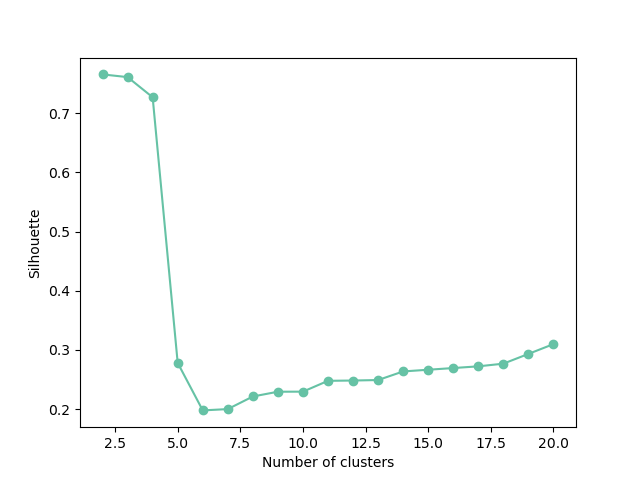

In [19]:
cal_silhouette(edge_mat, dim=21, method='agg')

In [20]:
start_time = time.time()
print(datetime.datetime.now())

cluster = AgglomerativeClustering(n_clusters=2, linkage='ward')
pred = cluster.fit_predict(edge_mat)

end_time = time.time()
print(datetime.datetime.now())
print('time spending: ', datetime.timedelta(seconds= (end_time - start_time)))

2021-11-12 18:39:27.599761
2021-11-12 18:41:26.654594
time spending:  0:01:59.054833


In [21]:
print(pred)

[0 0 0 ... 0 0 0]


#### Centrality

In [22]:
bet_cen = nx.betweenness_centrality(G)#(nx.to_undirected(G))
#sorted(bet_cen.items(), key = lambda x:x[1], reverse=True)
cls_cen = nx.closeness_centrality(G.reverse())
deg_cen = nx.degree_centrality(G)
in_deg_cen = nx.in_degree_centrality(G)
out_deg_cen = nx.out_degree_centrality(G)
page_rank = nx.pagerank(G)


In [23]:
a_list = list(REG_to_COM.values())
bet_cen_l = list(bet_cen.values())
cls_cen_l = list(cls_cen.values())
sorted(cls_cen_l, reverse=True)

[0.21739021740795905,
 0.21691700379823134,
 0.21362149894045226,
 0.2123154295629562,
 0.2102701891864323,
 0.20925272182343765,
 0.2085861905835559,
 0.20555561095355268,
 0.20487575419076717,
 0.20354751883944158,
 0.20318661898334328,
 0.2025223170568271,
 0.20230779964093146,
 0.2013480683591419,
 0.20117133872835183,
 0.20094205349220692,
 0.20076603557569309,
 0.20032733695761842,
 0.1988327459123894,
 0.19816229138268307,
 0.19715656448448277,
 0.19649734757648424,
 0.19575888812197748,
 0.19534177636854277,
 0.1951255799533554,
 0.19418326375769823,
 0.19413392022125295,
 0.1937728324426879,
 0.19351106569842216,
 0.19351106569842216,
 0.19347839457471824,
 0.19320113479997575,
 0.19289219509612124,
 0.19160216202408564,
 0.1905824931092726,
 0.1898405584471227,
 0.18954226448330402,
 0.18904198796866648,
 0.18893290430567244,
 0.18890176066365386,
 0.18832744964109388,
 0.1882346470213627,
 0.18774124034502884,
 0.18769511605373126,
 0.1874955057372474,
 0.1872351165862358,
 

In [36]:
output_df = pd.DataFrame(list(REG_to_COM.values()), columns=['REGISTRATION_NUMBER'])
output_df['COMPANY_NAME'] = company_name
output_df['INDUSTRY_CODE'] = industry_code
output_df['Scale'] = np.nan
output_df['Custom_value'] = np.nan
output_df['Product'] = np.nan
output_df['Transaction_frequency'] = dict(G.degree()).values()
output_df['Custom/Transaction'] = np.nan
output_df['Cluster_1'] = pred
output_df['Betweenness_Cen.'] = list(bet_cen.values())
output_df['B_rank'] = output_df['Betweenness_Cen.'].rank(method='dense', ascending=False)
output_df['Closeness_Cen.'] = list(cls_cen.values())
output_df['C_rank'] = output_df['Closeness_Cen.'].rank(method='dense', ascending=False)
output_df['Degree_Cen.'] = list(deg_cen.values())
output_df['D_rank'] = output_df['Degree_Cen.'].rank(method='dense', ascending=False)
output_df['In-Degree_Cen.'] = list(in_deg_cen.values())
output_df['ID_rank'] = output_df['In-Degree_Cen.'].rank(method='dense', ascending=False)
output_df['Out-Degree_Cen.'] = list(out_deg_cen.values())
output_df['OD_rank'] = output_df['Out-Degree_Cen.'].rank(method='dense', ascending=False)
output_df['PageRank'] = list(page_rank.values())
output_df['PR_rank'] = output_df['PageRank'].rank(method='dense', ascending=False)
output_df

,REGISTRATION_NUMBER,COMPANY_NAME,INDUSTRY_CODE,Scale,Custom_value,Transaction_frequency,Product,Cluster_1,Betweenness_Cen.,B_rank,Closeness_Cen.,C_rank,Degree_Cen.,D_rank,In-Degree_Cen.,ID_rank,Out-Degree_Cen.,OD_rank,PageRank,PR_rank
0,6088156952,(주)부일,C30122,NaN,NaN,39,NaN,0,0.005966,54.0,0.144812,1450.0,0.006377,90.0,0.004578,64.0,0.001799,60.0,0.000668,295.0
1,7018100489,(주)성진테크,C30201,NaN,NaN,23,NaN,0,0.000061,1295.0,0.000164,3369.0,0.003761,106.0,0.003597,70.0,0.000164,70.0,0.000824,230.0
2,8558801144,김포현대일급자동차공업사(주),C30122,NaN,NaN,8,NaN,0,0.000478,629.0,0.120686,2957.0,0.001308,121.0,0.000654,88.0,0.000654,67.0,0.000355,568.0
3,1378164867,(주)금강특장차,C30110,NaN,NaN,28,NaN,0,0.002090,202.0,0.137588,1997.0,0.004578,101.0,0.003761,69.0,0.000818,66.0,0.000813,233.0
4,1378167656,(주)태영특장,C30201,NaN,NaN,2,NaN,0,0.000000,2288.0,0.116674,3075.0,0.000327,127.0,0.000164,91.0,0.000164,70.0,0.000107,1554.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6112,3091300800,오티테크,C30400,NaN,NaN,1,NaN,0,0.000000,2288.0,0.130079,2490.0,0.000164,128.0,0.000000,92.0,0.000164,70.0,0.000032,2490.0
6113,2320301344,미르정공,C30400,NaN,NaN,1,NaN,0,0.000000,2288.0,0.117967,3037.0,0.000164,128.0,0.000000,92.0,0.000164,70.0,0.000032,2490.0
6114,6208153182,한올협동조합,C30400,NaN,NaN,2,NaN,0,0.000000,2288.0,0.129426,2531.0,0.000327,127.0,0.000000,92.0,0.000327,69.0,0.000032,2490.0
6115,7828801244,(주)그린라인,C30400,NaN,NaN,1,NaN,0,0.000000,2288.0,0.133301,2278.0,0.000164,128.0,0.000000,92.0,0.000164,70.0,0.000032,2490.0


## 매출액, 기업 데이터 불러오기

In [25]:
# 매출액 데이터
custom_df = pd.read_csv('dataset/기업정보 및 매출액.txt', sep='\t', encoding='CP949')
custom_df.drop_duplicates(inplace=True)
custom_df.tail()

,REGISTRATION_NUMBER,CORPORATE_NUMBER,COMPANYNAME,SCALE,REPRESENTATIVE,INDUSTRY_CODE,CODENM_KR,2018,2019,2020
407153,8638101812,1.341111e+12,(주)제이제이뮤즈,중소기업,조한림,G47912,전자상거래 소매업,NaN,NaN,71003.0
407154,7748801471,1.101118e+12,선빈어패럴(주),중소기업,장링,C14191,셔츠 및 블라우스 제조업,NaN,NaN,194910.0
407155,4978801797,1.401110e+12,(주)케이테크,중소기업,강경철,C33999,그 외 기타 달리 분류되지 않은 제품 제조업,NaN,NaN,391093.0
407156,3518102074,1.348111e+12,(주)사무퍼니처,중소기업,장승열,C32099,그 외 기타 가구 제조업,NaN,NaN,176470.0
407157,1400481992,NaN,정인유통,중소기업,유재현,G46325,커피 및 차류 도매업,1139559.0,1247170.0,NaN


In [26]:
# 기업 데이터
company_info_df = pd.read_csv('dataset/기업정보.txt', sep='\t', encoding='CP949', error_bad_lines=False)
company_info_df

b'Skipping line 162471: expected 32 fields, saw 34\n'
b'Skipping line 164323: expected 32 fields, saw 34\n'
C:\Users\IITP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,11,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,COMPANYID,REGISTRATION_NUMBER,CORPORATE_NUMBER,CODE,COMPANY_MAIN,SCALE,COMPANY_DETAIL,LISTED_MARKET,MANAGEMENT_ITEM_YN,EXTERNAL_AUDIT_YN,...,GROUP_CODE,INDUSTRY_CODE,BANK_CODE,BANK_OFFICE,BANK_OFFICE_ENG,PRODUCT,PRODUCT_ENG,HOMEPAGE,EMAIL,CLOSING_GUBUN
0,R63589,1099151008,NaN,0,9.0,2,0,9,N,N,...,NaN,10Q8620100,NaN,NaN,NaN,내과,NaN,NaN,NaN,X
1,AK3654,1293723222,NaN,0,8.0,2,0,9,N,N,...,NaN,10Q8620100,NaN,NaN,NaN,성형외과,NaN,NaN,NaN,X
2,FC7719,5131937397,NaN,0,9.0,2,0,9,N,N,...,NaN,10Q8620200,NaN,NaN,NaN,치과,NaN,NaN,NaN,X
3,LE9203,7715100346,NaN,0,9.0,2,0,9,N,N,...,NaN,10C3340100,NaN,NaN,NaN,완구 제조/출판/전자상거래,NaN,NaN,NaN,X
4,W99459,2159202041,NaN,0,9.0,2,0,9,N,N,...,NaN,10Q8620100,NaN,NaN,NaN,"산부인과,내과,소아과,피부과,이비인후과",NaN,NaN,NaN,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175676,LL1514,1090428716,NaN,0,9.0,2,0,9,N,N,...,NaN,10C2629000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X
175677,LL1515,1090442488,NaN,0,9.0,2,0,9,N,N,...,NaN,10C2812000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X
175678,LL1520,1090568068,NaN,0,9.0,2,0,9,N,N,...,NaN,10C2812000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X
175679,LL1712,1091575587,NaN,0,9.0,2,0,9,N,N,...,NaN,10C2700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X


In [52]:
# 매출액 데이터 합치기
custom_value = []
company_scale = []
product_list = []
for i in output_df['REGISTRATION_NUMBER']:
    tmp_custom = custom_df[custom_df['REGISTRATION_NUMBER'] == i][current_year].tolist()
    tmp_scale = custom_df[custom_df['REGISTRATION_NUMBER'] == i]['SCALE'].tolist()
    tmp_info = company_info_df[company_info_df['REGISTRATION_NUMBER'] == i]['PRODUCT'].tolist()
#     tmp = tmp.reset_index(drop=True)
    if tmp_custom:
        custom_value.append(tmp_custom[0])
    else:
        custom_value.append(np.nan)
        
    if tmp_scale:
        company_scale.append(tmp_scale[0])
    else:
        company_scale.append(np.nan)
        
    if tmp_info:
        product_list.append(tmp_info[0])
    else:
        product_list.append(np.nan)
        
len(custom_value)
output_df['Custom_value'] = custom_value
output_df['Product'] = product_list
output_df['Scale'] = company_scale
output_df['Custom/Transaction'] = output_df['Custom_value'] / output_df['Transaction_frequency']
output_df.head()

,REGISTRATION_NUMBER,COMPANY_NAME,INDUSTRY_CODE,Scale,Custom_value,Transaction_frequency,Product,Cluster_1,Betweenness_Cen.,B_rank,Closeness_Cen.,C_rank,Degree_Cen.,D_rank,In-Degree_Cen.,ID_rank,Out-Degree_Cen.,OD_rank,PageRank,PR_rank
0,6088156952,(주)부일,C30122,중소기업,2380822.0,39,"냉동탑차,소방차,경광등,자동차부품,경찰차,특장차 제조/자동차용품,경광등 도소매/자동...",0,0.005966,54.0,0.144812,1450.0,0.006377,90.0,0.004578,64.0,0.001799,60.0,0.000668,295.0
1,7018100489,(주)성진테크,C30201,중소기업,5777041.0,23,NaN,0,0.000061,1295.0,0.000164,3369.0,0.003761,106.0,0.003597,70.0,0.000164,70.0,0.000824,230.0
2,8558801144,김포현대일급자동차공업사(주),C30122,중소기업,1762328.0,8,NaN,0,0.000478,629.0,0.120686,2957.0,0.001308,121.0,0.000654,88.0,0.000654,67.0,0.000355,568.0
3,1378164867,(주)금강특장차,C30110,중소기업,6485966.0,28,"자동차, 특수목적차량, 특장차, 특수차,상업 및 산업용 조립건물 제조,푸드트럭,캠...",0,0.002090,202.0,0.137588,1997.0,0.004578,101.0,0.003761,69.0,0.000818,66.0,0.000813,233.0
4,1378167656,(주)태영특장,C30201,NaN,NaN,2,NaN,0,0.000000,2288.0,0.116674,3075.0,0.000327,127.0,0.000164,91.0,0.000164,70.0,0.000107,1554.0


### save as excel file

In [54]:
output_df.to_excel('{}_{}_1st_2cluster.xlsx'.format(current_industry_code, current_year))

## 모듈 데이터

In [57]:
calculate_module_parameter(output_df, step=1)

0  the number of nodes:  6108
0  module's B Cen. Avg: 0.00026875
0  module's C Cen. Avg: 0.12258522
0  module's OD Cen. Avg: 0.00058978
0  module's OD Cen. STD.dev: 0.00113217
0  module's ID Cen. Avg: 0.00059741
0  module's ID Cen. STD.dev: 0.00170720
0  module's C30 :  6108
0  module's not C30 :  0

1  the number of nodes:  9
1  module's B Cen. Avg: 0.02206524
1  module's C Cen. Avg: 0.20816642
1  module's OD Cen. Avg: 0.01998401
1  module's OD Cen. STD.dev: 0.01082621
1  module's ID Cen. Avg: 0.01480634
1  module's ID Cen. STD.dev: 0.01455987
1  module's C30 :  9
1  module's not C30 :  0



,# of in_industry,Custom avg.,Custom rank,Bet. avg.,Bet. rank,Cls. avg.,Cls. rank,OD avg.,OD rank,ID avg.,ID rank,OD/ID
0,6108,7.287955e+07,2.0,0.000269,2.0,0.122585,2.0,0.000590,2.0,0.000597,2.0,0.987229
1,9,9.014803e+08,1.0,0.022065,1.0,0.208166,1.0,0.019984,1.0,0.014806,1.0,1.349693


### 2nd step clustering

In [41]:
kclu_df = output_df[output_df['Cluster_1'] == 0]   # 두번쨰 클러스터링에 넣을 모듈 넘버 설정
# kclu_df = output_df[output_df['INDUSTRY_CODE'].str.contains("C2611") == True]
features = kclu_df[['Betweenness_Cen.','Closeness_Cen.','In-Degree_Cen.','Out-Degree_Cen.','PageRank']]

processing 2 clusters agglomerative
processing 3 clusters agglomerative
processing 4 clusters agglomerative
processing 5 clusters agglomerative
processing 6 clusters agglomerative
processing 7 clusters agglomerative
processing 8 clusters agglomerative
processing 9 clusters agglomerative
processing 10 clusters agglomerative
processing 11 clusters agglomerative
processing 12 clusters agglomerative
processing 13 clusters agglomerative
processing 14 clusters agglomerative
processing 15 clusters agglomerative
processing 16 clusters agglomerative
processing 17 clusters agglomerative
processing 18 clusters agglomerative
processing 19 clusters agglomerative
processing 20 clusters agglomerative
processing 21 clusters agglomerative
processing 22 clusters agglomerative
processing 23 clusters agglomerative
processing 24 clusters agglomerative
processing 25 clusters agglomerative
processing 26 clusters agglomerative
processing 27 clusters agglomerative
processing 28 clusters agglomerative
processin

<IPython.core.display.Javascript object>


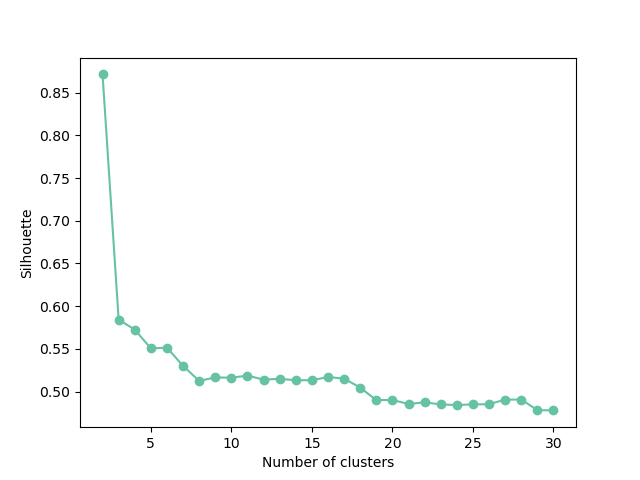

In [30]:
cal_silhouette(features, dim=31, method='agg')

In [43]:
cluster_n = 16   # 실루엣 스코어 기반 클러스터 갯수 인풋

# k-means
# kmeans = KMeans(n_clusters=cluster_n, n_init=10, random_state=42)   # 클러스터링 parameter check
# kmeans.fit(features)
# kclu_df['km_cluster'] = kmeans.labels_

# HC
agg2 = AgglomerativeClustering(n_clusters=cluster_n, linkage='ward')
agg2.fit(features)
kclu_df['Cluster_2'] = agg2.labels_

# print(kclu_df['km_cluster'].value_counts())
print(kclu_df['Cluster_2'].value_counts())
kclu_df

15    770
6     713
12    660
3     598
10    568
5     535
1     535
2     512
7     432
9     224
13    193
4     154
0     135
8      69
11      8
14      2
Name: Cluster_2, dtype: int64


<ipython-input-43-df2f13d37daa>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kclu_df['Cluster_2'] = agg2.labels_


,REGISTRATION_NUMBER,COMPANY_NAME,INDUSTRY_CODE,Scale,Custom_value,Transaction_frequency,Product,Cluster_1,Betweenness_Cen.,B_rank,...,C_rank,Degree_Cen.,D_rank,In-Degree_Cen.,ID_rank,Out-Degree_Cen.,OD_rank,PageRank,PR_rank,Cluster_2
0,6088156952,(주)부일,C30122,NaN,NaN,39,NaN,0,0.005966,54.0,...,1450.0,0.006377,90.0,0.004578,64.0,0.001799,60.0,0.000668,295.0,12
1,7018100489,(주)성진테크,C30201,NaN,NaN,23,NaN,0,0.000061,1295.0,...,3369.0,0.003761,106.0,0.003597,70.0,0.000164,70.0,0.000824,230.0,15
2,8558801144,김포현대일급자동차공업사(주),C30122,NaN,NaN,8,NaN,0,0.000478,629.0,...,2957.0,0.001308,121.0,0.000654,88.0,0.000654,67.0,0.000355,568.0,1
3,1378164867,(주)금강특장차,C30110,NaN,NaN,28,NaN,0,0.002090,202.0,...,1997.0,0.004578,101.0,0.003761,69.0,0.000818,66.0,0.000813,233.0,10
4,1378167656,(주)태영특장,C30201,NaN,NaN,2,NaN,0,0.000000,2288.0,...,3075.0,0.000327,127.0,0.000164,91.0,0.000164,70.0,0.000107,1554.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6112,3091300800,오티테크,C30400,NaN,NaN,1,NaN,0,0.000000,2288.0,...,2490.0,0.000164,128.0,0.000000,92.0,0.000164,70.0,0.000032,2490.0,5
6113,2320301344,미르정공,C30400,NaN,NaN,1,NaN,0,0.000000,2288.0,...,3037.0,0.000164,128.0,0.000000,92.0,0.000164,70.0,0.000032,2490.0,1
6114,6208153182,한올협동조합,C30400,NaN,NaN,2,NaN,0,0.000000,2288.0,...,2531.0,0.000327,127.0,0.000000,92.0,0.000327,69.0,0.000032,2490.0,5
6115,7828801244,(주)그린라인,C30400,NaN,NaN,1,NaN,0,0.000000,2288.0,...,2278.0,0.000164,128.0,0.000000,92.0,0.000164,70.0,0.000032,2490.0,7


In [44]:
kclu_df.to_excel('{}_{}_2nd_16cluster.xlsx'.format(current_industry_code, current_year))

In [55]:
calculate_module_parameter(kclu_df, step=2)

0  the number of nodes:  135
0  module's B Cen. Avg: 0.00385418
0  module's C Cen. Avg: 0.18264450
0  module's OD Cen. Avg: 0.00483250
0  module's OD Cen. STD.dev: 0.00236027
0  module's ID Cen. Avg: 0.00613449
0  module's ID Cen. STD.dev: 0.00439123
0  module's C30 :  135
0  module's not C30 :  0

1  the number of nodes:  535
1  module's B Cen. Avg: 0.00003639
1  module's C Cen. Avg: 0.12099976
1  module's OD Cen. Avg: 0.00021515
1  module's OD Cen. STD.dev: 0.00013330
1  module's ID Cen. Avg: 0.00013386
1  module's ID Cen. STD.dev: 0.00035411
1  module's C30 :  535
1  module's not C30 :  0

2  the number of nodes:  512
2  module's B Cen. Avg: 0.00042943
2  module's C Cen. Avg: 0.16131352
2  module's OD Cen. Avg: 0.00116849
2  module's OD Cen. STD.dev: 0.00098496
2  module's ID Cen. Avg: 0.00103436
2  module's ID Cen. STD.dev: 0.00170234
2  module's C30 :  512
2  module's not C30 :  0

3  the number of nodes:  598
3  module's B Cen. Avg: 0.00026558
3  module's C Cen. Avg: 0.15367015
3

,# of in_industry,Custom avg.,Custom rank,Bet. avg.,Bet. rank,Cls. avg.,Cls. rank,OD avg.,OD rank,ID avg.,ID rank,OD/ID
0,135,NaN,NaN,0.003854,3.0,0.182645,3.0,0.004832,3.0,0.006134,3.0,0.787759
1,535,NaN,NaN,0.000036,12.0,0.121000,12.0,0.000215,13.0,0.000134,15.0,1.607306
2,512,NaN,NaN,0.000429,5.0,0.161314,5.0,0.001168,5.0,0.001034,5.0,1.129670
3,598,NaN,NaN,0.000266,6.0,0.153670,6.0,0.000751,6.0,0.000739,6.0,1.017031
4,154,NaN,NaN,0.000067,9.0,0.105787,14.0,0.000239,12.0,0.000229,12.0,1.041667
5,535,NaN,NaN,0.000027,14.0,0.127620,11.0,0.000240,11.0,0.000165,14.0,1.452865
6,713,NaN,NaN,0.000141,7.0,0.146623,7.0,0.000605,7.0,0.000495,7.0,1.221965
7,432,NaN,NaN,0.000040,11.0,0.132159,10.0,0.000269,10.0,0.000234,11.0,1.152104
8,69,NaN,NaN,0.000035,13.0,0.088614,15.0,0.000192,15.0,0.000173,13.0,1.109589
9,224,NaN,NaN,0.000881,4.0,0.170213,4.0,0.002031,4.0,0.001869,4.0,1.087109
